In [1]:
# MAKE A PIPELINE FOR PROCESSING THE COLOR IMAGES!
# FROM TIRAMISU
# IDEA: Add neck to the posture map?
# %matplotlib inline
# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import sys, os, pickle
import cv2
from colour import Color
import h5py
from tqdm import tqdm, tqdm_notebook
import os
import sys
import math
import string
import random
import shutil
import glob

In [2]:
# Check CUDA

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
torch_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch_device)

True
1
GeForce RTX 2080 Ti
cuda:0


In [3]:
# Load the tesiting dataset of 

In [5]:
N_STACKS = 3
WEIGHTS_PATH = '/media/chrelli/SSD4TB/revision_profiling/{}_STACKS/'.format(N_STACKS)
EPOCH = 50

def load_model(WEIGHTS_PATH,N_STACKS,EPOCH,verbose=False):
    # Load a model!
    # import the hourglass model and set up architecture
    from architectures.hourglass import hg
    global best_acc

    model = hg(
        num_stacks=N_STACKS,
        num_blocks=1,
        num_channels=1,
        num_classes=11,
        num_feats=128,
        inplanes=64,
        init_stride=2,
    )

    model = torch.nn.DataParallel(model).cuda()


    # A HELPER FUNCTION WHICH SAVES THE STATE OF THE NETWORK, maybe every 10 epochs or smth?
    import os
    import sys
    import math
    import string
    import random
    import shutil
    import glob

    # Find the path to the saved weights
    all_options = sorted( glob.glob(WEIGHTS_PATH + '/singlecore_weights_epoch_'+str(EPOCH)+'*' ) )
    if verbose:
        print(all_options)
    weights_fpath = all_options[0]
    if verbose:
        print("loading weights '{}'".format(weights_fpath))
    model.load_state_dict( torch.load(weights_fpath) )
    model.eval()
    if verbose:
        print('loaded!')
    return model

model = load_model(WEIGHTS_PATH,N_STACKS,EPOCH, verbose = True)

['/media/chrelli/SSD4TB/revision_profiling/3_STACKS/singlecore_weights_epoch_50_loss_42.089_2020-10-26_22-13-18.pth']
loading weights '/media/chrelli/SSD4TB/revision_profiling/3_STACKS/singlecore_weights_epoch_50_loss_42.089_2020-10-26_22-13-18.pth'
loaded!


['/media/chrelli/SSD4TB/Data0_backup/recording_20200828-114251/mouse_training_set.h5']
['training_sets/skeleton_v2_mice.csv']
<KeysViewHDF5 ['annotated', 'annotations', 'c_images', 'skeleton']>


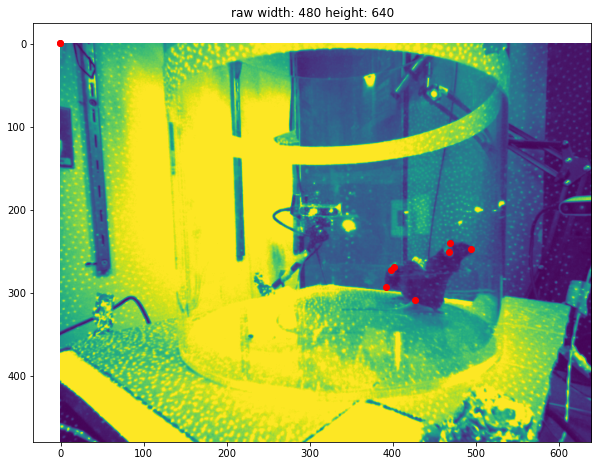

In [9]:
# Load the validation dataset!

# training data with different exposure
top_folder_0 = '/media/chrelli/Data0/recording_20200828-113642/'
top_folder_1 = '/media/chrelli/Data1/recording_20200828-113642/'
top_folder_0 = '/media/chrelli/SSD4TB/Data0_backup/recording_20200828-113642/'
top_folder_1 = '/media/chrelli/SSD4TB/Data1_backup/recording_20200828-113642/'





# validation dataset with LASER ON 90 fps
top_folder_0 = '/media/chrelli/Data0/recording_20200828-114251/'
top_folder_1 = '/media/chrelli/Data1/recording_20200828-114251/'
top_folder_0 = '/media/chrelli/SSD4TB/Data0_backup/recording_20200828-114251/'
top_folder_1 = '/media/chrelli/SSD4TB/Data1_backup/recording_20200828-114251/'


training_sets = glob.glob( top_folder_0 + '/*.h5')
skeletons = glob.glob('training_sets' + '/*skeleton_v2*')

print(training_sets)
print(skeletons)

h5_path = training_sets[0]
h5_file = h5py.File(h5_path, 'r')

from c_utils.utils_hour import check_h5_ir
pic = check_h5_ir(h5_path)


In [7]:
# make a minimal dataset to loop over the frames!!
# https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel
import torch
import torch.utils.data as data
import imgaug.augmenters as iaa

from c_utils.utils_hour import gaussian

# HACK for imgaug for now, numpy had a code change in 1.8
# import numpy
# numpy.random.bit_generator = numpy.random._bit_generator


selfseq = iaa.Sequential([
        #     iaa.Crop(px=(0, 100)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.CropAndPad(percent=(-0.10, 0.15), sample_independently=False),
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.Sometimes(.3, iaa.GaussianBlur(sigma=(0, 1.5)) ), # blur images with a sigma of 0 to 3.0
            iaa.Sometimes( 1, iaa.Dropout(p = (0,0.2)) ),
            iaa.Affine(rotate=(-30, 30),
                       translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
        ],random_order=True)
   
snowflakes = iaa.Snowflakes(flake_size=(0.5, 0.7), speed=(0.001, 0.003), density_uniformity=(0.99, 1.))
# pic_snow = snowflakes.augment_image(pic)

class MouseDataset(data.Dataset):
    # todo add augmentation here, clean up and make faster
    # todo remove stupid side effects etc
    def __init__(self, h5_data,which_indices,augmentation=False):
        '''Initialization'''
        self.label_names = ['impl','ear','ear','nose','tail','ear','ear','nose','tail']
        self.label_index = [0,1,1,1,1,2,2,3,3]
        
        # index for loading subsets from the h5 file
        self.which_indices = which_indices       
        self.n_images = len(which_indices)
    

        # FOR THE AUGMENTATION PIPELINE

        self.seq = iaa.Sequential([
        #     iaa.Crop(px=(0, 100)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.CropAndPad(percent=(-0.10, 0.15), sample_independently=False),
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.Sometimes(.3, iaa.GaussianBlur(sigma=(0, 1.5)) ), # blur images with a sigma of 0 to 3.0
            iaa.Sometimes( 1, iaa.Dropout(p = (0,0.2)) ),
            iaa.Affine(rotate=(-30, 30),
                       translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)})
        ],random_order=False)
        
        self.augmentataion = augmentation
       
    def __len__(self):
        'Denotes the total number of samples'
        return self.n_images    
        
    def __getitem__(self, index):
        # will be i x j x 1 - is that ok?
        # todo check if this moveaxis is good?
        # im = np.moveaxis(h5_data['c_images'][self.which_indices[index]],[0,1],[1,2])
#         tracking_folder = '/home/chrelli/Documents/Example3D_compressed'
#         h5_path = tracking_folder + '/mouse_rgbd_annotation_set.h5'
#         h5_path = 'training_sets/mouse_training_set_labeled.h5'
        with h5py.File(h5_path, 'r') as h5_file:
            xy = h5_file['annotations'][self.which_indices[index]]
            c_image = h5_file['c_images'][self.which_indices[index]]
            # dac_image = h5_file['dac_images'][self.which_indices[index]]
        
       
        # check if the points are good before augmentation
        # upper left corner is trash
        point_good = (xy[:,0] > 30)*( xy[:,1] > 30)
        
        # NOW, AUGMENT!
        # TODO AUGMENT DEPTH AS WELL?
        # AUGMENT DEPTH BY DEAD BLOCKS TO SIMULATE REAL DATA?
        
        high_res = True        

        if self.augmentataion and not high_res:
            #HACK: selfseq instead of self.seq
            images_aug, xy_aug_list = self.seq(images = c_image[np.newaxis,:,:,:], keypoints=[xy])
            xy = xy_aug_list[0]
            c_image = images_aug[0,:,:,:]
            
        if self.augmentataion and high_res:
            #HACK: selfseq instead of self.seq
            images_aug, xy_aug_list = self.seq(images = c_image[np.newaxis,:,:], keypoints=[xy])
            xy = xy_aug_list[0]
            c_image = images_aug[0,:,:]
            
            
        snowflakes = iaa.Snowflakes(flake_size=(0.1, 0.4), speed=(0.00, 0.00),
                                density = (.001,.1), density_uniformity=(0.99, 1.))
        add_snow = False 
        if add_snow:
            c_image = snowflakes.augment_image(c_image)            
            
        # pack depth and pixels to target - OR NOT??
        im = c_image
        frame_height = im.shape[0]
        frame_width = im.shape[1]
        
        if high_res:
            # size is 
            pad_right = 0
            pad_top = 480-448 - 2
            pad_bottom = 2

            
            im = im[pad_top:-pad_bottom,:]
            # and make the image Chan X heigh X width
            im = im[np.newaxis,:,:]
        else:
            # make the resolution correct, i.e. set the height to 192
            pad_top = 8
            pad_bottom = 10
            
            im = im[pad_top:-pad_bottom,:,:]
        
            # and make the image Chan X heigh X width
            im = np.moveaxis(im,2,0)
        
        # recale the keypoints
        xy[:,1] -= pad_top
            
        rescale = True
        h_out,w_out = im.shape[1],im.shape[2]
        label_sigma = np.array([2,1,1,1,1,1,1,1,1]) *1.5 *2
        gaussian_sigma = (15,15)
        line_thickness = 3
        
        if rescale:
            # halved
            h_out,w_out = int(h_out/4),int(w_out/4)
            xy = np.round(xy/4).astype('int')
            if high_res:
                label_sigma = np.array([3,1,1,1,1,1,1,1,1]) 
                gaussian_sigma = (3,3)
                line_thickness = 2
            else:
                label_sigma = np.array([3,1,1,1,1,1,1,1,1]) 
                gaussian_sigma = (3,3)
                line_thickness = 1

        label_names = ['impl','ear','ear','nose','tail','ear','ear','nose','tail']
        body_names = ['mouse0','mouse0','mouse0','mouse0','mouse0','mouse1','mouse1','mouse1','mouse1']
        label_index = [0,1,1,2,3,1,1,2,3]
        body_index = [0,0,0,0,0,1,1,1,1]

        # target has to be batch x n_features x pic_i x pic_j
        target_points = np.zeros((4,h_out,w_out))
        img = target_points[0,:,:].copy()

        for i in range(9):
            if point_good[i]:
                target_points[label_index[i],:,:] += ( gaussian(img.copy(), xy[i,:], label_sigma[i]) )        

        # draw the lines within the body!
        xy_good = xy[point_good]
        label_good = xy[point_good]
        body_good = xy[point_good]


        target_lines = []

        def draw_lines(p1,p2):
            img_blank = np.zeros((h_out,w_out)).astype('uint8')
            for i1,i2 in zip(p1,p2):
                if point_good[i1]*point_good[i2]:
                    start = tuple(np.round(xy[i1,:]).astype('int') )
                    end = tuple(np.round(xy[i2,:]).astype('int') )
                    cv2.line(img_blank,start,end,[255,255,255],thickness = line_thickness)
                img_blank = np.clip(img_blank,0,255)
                img_blank = cv2.GaussianBlur(img_blank,gaussian_sigma,0)
            img_blank = img_blank/255
            target_lines.append(img_blank.copy())            
            
        # I to ears
        p1,p2 = [0,0],[1,2]
        draw_lines(p1,p2)

        # I to nose
        p1,p2 = [0],[3]
        draw_lines(p1,p2)

        # I to tail
        p1,p2 = [0],[4]
        draw_lines(p1,p2)

        # Ear to Ear
        p1,p2 = [1,5],[2,6]
        draw_lines(p1,p2)

        # Ear to Tail
        p1,p2 = [1,2,5,6],[4,4,8,8]
        draw_lines(p1,p2)

        # Ear to Nose
        p1,p2 = [1,2,5,6],[3,3,7,7]
        draw_lines(p1,p2)

        # Nose to Tail
        p1,p2 = [3,7],[4,8]
        draw_lines(p1,p2)

        # stack all the targets
        target_lines = np.concatenate([t[np.newaxis,:,:] for t in target_lines],axis=0)
        target = np.concatenate((target_points,target_lines),axis = 0)
        
        # convert to sensible ranges
        im = im / 255.
        
        im = np.clip(im,0,1)
        
        # from documentation    
        # For a conv2D, input should be in (N, C, H, W) format. N is the number of samples/batch_size. C is the channels. H and W are height and width resp.
        # See shape documentation at https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d    
        # so im is (batch, channels, H, W) 
        # target is (n_trained_features, H, W) 
        
        return im.astype('float32'),target.astype('float32'),xy_good,point_good,label_index

# # separate by pseudo-random indices
np.random.seed(0)

with h5py.File(h5_path, 'r') as h5_file:
    n_frames = h5_file['c_images'].shape[0]
    print("n_frames = " +str(n_frames) )
# n_frames = 576
random_indices = np.random.permutation(n_frames)

MouseTrain = MouseDataset(h5_file,random_indices[:],augmentation=False)

# we shuffle, so that we always see different dumps
# MouseTrainLoader = data.DataLoader(MouseTrain, batch_size=1, shuffle=True, num_workers = 1)
MouseTrainLoader = data.DataLoader(MouseTrain, batch_size=1, shuffle=False,num_workers = 0)

print("training augment = {}".format(MouseTrain.augmentataion) )


n_frames = 720
training augment = False


torch.Size([1, 1, 448, 640])
torch.float32
tensor(1.)


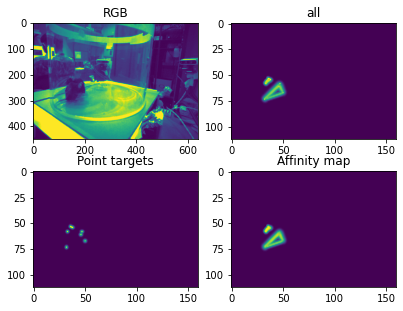

In [8]:
# check that the bechmark loading works
from c_utils.utils_hour import plot_im_target,plot_im_target_ir, random_from
for i in range(1):    
#     im,target = random_from( MouseTrainLoader)
    im,target,xy,point_good,lab = next(iter( MouseTrainLoader))
    print(im.shape)
    print(im.dtype)
    print(torch.max(im))

    plot_im_target_ir(im,target,5)    

In [9]:
# define a loss function 


# custom loss function for weighing
def weighted_mse_loss(input, target, weights):
    out = (input - target) ** 2
    out = out * weights.expand_as(out)
    loss = out.sum()
    return loss

# also load a summary_writer for tensorboard
def weighted_hourglass_loss(inputs,targets,output):
    # loss_weight = torch.ones((inputs.size(0), args.num_classes, 1, 1))
    loss_weight = torch.ones((inputs.size(0), targets.size(1), 1, 1))
    
    loss_weight.requires_grad = True
    loss_weight = loss_weight.cuda()

    # add all the loss maps together (8 hourglasses)
    loss = weighted_mse_loss(output[0], targets, weights=loss_weight)
    for j in range(1, len(output)):
        loss += weighted_mse_loss(output[j], targets, weights=loss_weight)

    return loss


# also load a summary_writer for tensorboard
def weighted_hourglass_loss_final_stack(inputs,targets,output):
    # loss_weight = torch.ones((inputs.size(0), args.num_classes, 1, 1))
    loss_weight = torch.ones((inputs.size(0), targets.size(1), 1, 1))
    
    loss_weight.requires_grad = True
    loss_weight = loss_weight.cuda()

    # add all the loss maps together (8 hourglasses)
    loss = weighted_mse_loss(output[-1], targets, weights=loss_weight)

    return loss

# also load a summary_writer for tensorboard
def weighted_hourglass_loss_final_stack(inputs,targets,output):
    
    
    # loss_weight = torch.ones((inputs.size(0), args.num_classes, 1, 1))
    loss_weight = torch.ones((inputs.size(0), targets.size(1), 1, 1))
    
    loss_weight.requires_grad = True
    loss_weight = loss_weight.cuda()

    # add all the loss maps together (8 hourglasses)
    loss = weighted_mse_loss(output[-1], targets, weights=loss_weight)

    return loss


# also load a summary_writer for tensorboard
def weighted_hourglass_loss_final_noPAF(inputs,targets,output):
    targets = targets[:,:4,:,:]
    output = [o[:,:4,:,:] for o in output]
    
    # loss_weight = torch.ones((inputs.size(0), args.num_classes, 1, 1))
    loss_weight = torch.ones((inputs.size(0), targets.size(1), 1, 1))
    
    loss_weight.requires_grad = True
    loss_weight = loss_weight.cuda()

    # add all the loss maps together (8 hourglasses)
    loss = weighted_mse_loss(output[-1], targets, weights=loss_weight)

    return loss

In [10]:
# a function to get out the keypoints 

from skimage.feature import peak_local_max

def single_score_2_keypoints(sco):
    xy_list = [None]*4
    pxy_list = [None]*4
    score_idx_list = [None]*4
    for key in range(4):
        xy = peak_local_max(sco[key,:,:],threshold_abs = 0.1,num_peaks = 6)
        xy_list[key] = xy
        pxy_list[key] = sco[key,xy[:,0],xy[:,1]]
        # print(xy.shape)
        score_idx_list[key] = key * np.ones_like(xy)

    return np.concatenate(xy_list), np.concatenate(pxy_list), np.concatenate(score_idx_list)


In [11]:
# make a function which will do a training step!
from torch.autograd import Variable

def test(model, trn_loader,noPAF = False):
    model.eval()
    epoch_loss = 0
    frame_loss = []
    xy_list = []
    pxy_list = []
    score_idx_list = []
    
    xy_real_list = []
    score_idx_real_list = []   
    
    # trn_error = 0
    for idx, data in tqdm(enumerate(trn_loader)):
        
        # Hack for faster look
        if idx == -30:
            return epoch_loss, frame_loss, xy_list, pxy_list, score_idx_list, xy_real_list, score_idx_real_list   #, trn_error
                
        ### PREPARE TENSORS ###
        
        # make right byte and shape (# remove the depth dimension)

        inputs = data[0].float()
        targets = data[1].float()
        
        # send to cuda
        inputs = Variable(inputs.cuda())
        targets = Variable(targets.cuda(non_blocking=True))

        ### CALC LOSS W/O GRAD ###
        
        with torch.no_grad():
            # compute model output
            output = model(inputs)   
            
            if noPAF:
                # drop the PAFs from the score
                loss = weighted_hourglass_loss_final_noPAF(inputs,targets,output)
            else:
                loss = weighted_hourglass_loss_final_stack(inputs,targets,output)
                
            # and check the score to get the keypoints
            sco = output[-1][:,:4,:,:].cpu().numpy()
            
        xy, pxy, score_idx = single_score_2_keypoints(sco[0,...])
        

        xy_list.append(xy)
        pxy_list.append(pxy)
        score_idx_list.append(score_idx)
    
        xy_real = data[2].squeeze().cpu().numpy()
        logi = data[3].squeeze().cpu().numpy()
        lab_real = np.array([0,1,1,2,3,1,1,2,3])[logi]

        
        xy_real_list.append(xy_real)
        score_idx_real_list.append(lab_real)   
        
        
        epoch_loss += loss.item()
        frame_loss.append(loss.item())
        
    epoch_loss /= len(trn_loader)
    # trn_error /= len(trn_loader)
    return epoch_loss, frame_loss, xy_list, pxy_list, score_idx_list, xy_real_list, score_idx_real_list   #, trn_error


epoch_loss, frame_loss, xy_list, pxy_list, score_idx_list, xy_real_list, score_idx_real_list  = test(model, MouseTrainLoader, noPAF = True)

500it [00:16, 30.51it/s]


In [19]:
# Load the REAL xy and indices!



In [12]:
# epoch_loss, frame_loss = test(model, MouseTrainLoader)

In [12]:
N_STACKS = 3

ep_stack = []
frame_stack = []
keypoint_stack = []
all_stacks = [0,1,2]
for st in all_stacks:
    
    if st == 0:
        WEIGHTS_PATH = '/media/chrelli/SSD4TB/revision_profiling/{}_STACKS/'.format(3)
    if st == 1:
        WEIGHTS_PATH = '/media/chrelli/SSD4TB/revision_profiling/{}_STACKS_NOSNOW/'.format(3)
    if st == 2:
        WEIGHTS_PATH = '/media/chrelli/SSD4TB/revision_profiling/{}_STACKS_NOAUG/'.format(3)
        
        
    epoch_loss_list = []
    frame_loss_list = []
    keypoint_list = []
    
    test_epochs = np.hstack((np.arange(0,90,10),89))
    
    # only last
#     test_epochs = [89]
#     test_epochs = [10]

#     test_epochs = np.arange(0,90,10)
 
    if st == 9:
#         test_epochs =  np.hstack((np.arange(0,120,10),119))
#         test_epochs[-1] += 1
    
        test_epochs = [119]
    
    for ep in test_epochs:
        print("stack {}, ep {}".format(st,ep))
        model = load_model(WEIGHTS_PATH,3,ep)
        epoch_loss, frame_loss, xy_list, pxy_list, score_idx_list, xy_real_list, score_idx_real_list = test(model, MouseTrainLoader,noPAF = True)
        epoch_loss_list.append(epoch_loss)
        frame_loss_list.append(frame_loss)
        keypoint_list.append([xy_list, pxy_list, score_idx_list, xy_real_list, score_idx_real_list])
   
    ep_stack.append(epoch_loss_list)
    frame_stack.append(frame_loss_list)
    keypoint_stack.append(keypoint_list)

stack 0, ep 0


500it [00:14, 34.28it/s]


stack 0, ep 10


500it [00:14, 34.15it/s]


stack 0, ep 20


500it [00:14, 33.49it/s]


stack 0, ep 30


500it [00:14, 33.83it/s]


stack 0, ep 40


500it [00:14, 33.55it/s]
0it [00:00, ?it/s]

stack 0, ep 50


500it [00:14, 33.70it/s]


stack 0, ep 60


500it [00:14, 33.86it/s]


stack 0, ep 70


500it [00:14, 33.72it/s]


stack 0, ep 80


500it [00:14, 33.90it/s]


stack 0, ep 89


500it [00:14, 33.82it/s]


stack 1, ep 0


500it [00:14, 33.79it/s]


stack 1, ep 10


500it [00:14, 33.86it/s]


stack 1, ep 20


500it [00:14, 33.71it/s]


stack 1, ep 30


500it [00:14, 33.86it/s]


stack 1, ep 40


500it [00:14, 33.74it/s]


stack 1, ep 50


500it [00:14, 33.86it/s]


stack 1, ep 60


500it [00:14, 33.74it/s]


stack 1, ep 70


500it [00:14, 33.86it/s]


stack 1, ep 80


500it [00:14, 33.87it/s]


stack 1, ep 89


500it [00:14, 33.70it/s]


stack 2, ep 0


500it [00:14, 33.76it/s]


stack 2, ep 10


500it [00:14, 33.71it/s]


stack 2, ep 20


500it [00:14, 33.73it/s]


stack 2, ep 30


500it [00:14, 33.68it/s]


stack 2, ep 40


500it [00:14, 33.65it/s]


stack 2, ep 50


500it [00:14, 33.70it/s]


stack 2, ep 60


500it [00:14, 33.78it/s]


stack 2, ep 70


500it [00:14, 33.58it/s]


stack 2, ep 80


500it [00:14, 33.62it/s]


stack 2, ep 89


500it [00:14, 33.81it/s]


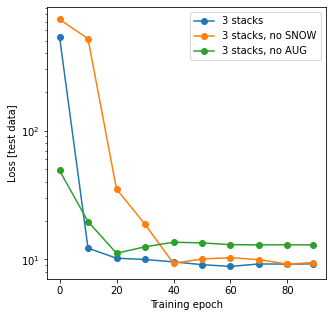

In [33]:
from palettable.tableau import GreenOrange_6, Tableau_10
cc = GreenOrange_6.mpl_colors
cc = Tableau_10.mpl_colors

plt.figure(figsize = (5,5) )
for i_st,st in enumerate(all_stacks):
    
    test_epochs = np.hstack((np.arange(0,90,10),89))
    if st == 9:
#         test_epochs = np.hstack((np.arange(0,120,10),119))
        test_epochs[-1] += 1
    
#     plt.plot(test_epochs,np.log(ep_stack[i]),'o-',label = "{} stacks".format(st) )
    
    sigma = 2
#     for i_ep,ep in enumerate(test_epochs):
#         dat = frame_stack[i_st][i_ep]
#         plt.plot(ep * np.ones_like(dat) + sigma*np.random.normal(size = len(dat),loc = 0), dat,'.' , alpha = 0.41 ,c=cc[i_st] )
    
    
    median_loss = [np.median(fr) for fr in frame_stack[i_st] ]
    mean_loss = [np.mean(fr) for fr in frame_stack[i_st] ]

#     plt.plot(test_epochs,median_loss,'o-',label = "{} stacks".format(st) ,c=cc[i_st])
    if st == 0:
        plt.plot(test_epochs,mean_loss,'o-',label = "3 stacks" ,c=cc[i_st])

    if st == 1:
        plt.plot(test_epochs,mean_loss,'o-',label = "3 stacks, no SNOW" ,c=cc[i_st])

    if st == 2:
        plt.plot(test_epochs,mean_loss,'o-',label = "3 stacks, no AUG" ,c=cc[i_st])

        
ax = plt.gca()    
ax.set_yscale('log')
    
plt.legend()
plt.ylabel("Loss [test data]")
# plt.ylabel("log(Loss) [only ]")
plt.xlabel("Training epoch")

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'AUG_test.pdf',transparent=True,  bbox_inches='tight')

plt.show()

In [34]:
# also plot the learning rate and the training loss as a func of iterations and time 

logdir = '/home/chrelli/git/3ddd_mouse_tracker/analysis/runs/'

stack_list = [0,1,2]
aug_name = ['3 stacks','3 stacks, no SNOW', '3 stacks, no AUG']
tag_list = ['Oct26_20-51-12_CE-01','Oct27_14-42-04_CE-01','Oct27_16-59-51_CE-01']

# from here https://gist.github.com/tomrunia/1e1d383fb21841e8f144

# from tensorflow.python.summary.event_accumulator import EventAccumulator
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib as mpl
import matplotlib.pyplot as plt

# Loading too much data is slow...
tf_size_guidance = {
        'compressedHistograms': 10,
        'images': 0,
        'scalars': 100,
        'histograms': 1
    }


def extract_as_arrays(lr):
    # unpacks from the tensorboard logs
    lr_v = np.array([x[2] for x in lr])
    # the steps
    lr_s = np.array([x[1] for x in lr])
    # get the time and zero to first time
    lr_t = np.array([x[0] for x in lr])
    lr_t -= lr_t[0]
    
    return [lr_t,lr_s,lr_v]



{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


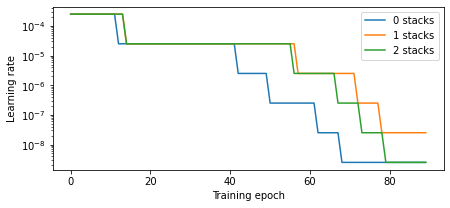

In [35]:
from palettable.tableau import GreenOrange_6, Tableau_10
cc = GreenOrange_6.mpl_colors
cc = Tableau_10.mpl_colors


# plot the learninig rate
i_stack = 0
fig = plt.figure(figsize = (7,3) )

for i_stack,st in enumerate(stack_list):

    tensorboard_path = glob.glob(logdir+tag_list[i_stack]+'/*')[0]

    # read the data
    event_acc = EventAccumulator(tensorboard_path)
    event_acc.Reload()

    # Show all tags in the log file
    print(event_acc.Tags())

    trn_loss =   event_acc.Scalars('trn_loss')
    trn_frame_loss =   event_acc.Scalars('trn_frame_loss')

    val_loss =   event_acc.Scalars('val_loss')
    val_frame_loss =   event_acc.Scalars('val_frame_loss')

    lr = event_acc.Scalars('lr')
    n_stacks = event_acc.Scalars('n_stakcs')

    # convert
    trn_loss = extract_as_arrays(trn_loss)
    trn_frame_loss = extract_as_arrays(trn_frame_loss)
    n_stacks = extract_as_arrays(n_stacks)
    lr = extract_as_arrays(lr)

    plt.plot(lr[1][:90],lr[2][:90],c=cc[i_stack],label = "{} stacks".format(st))

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
plt.ylabel("Learning rate")
# plt.ylabel("log(Loss) [only ]")
plt.xlabel("Training epoch")

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'AUG_lr.pdf',transparent=True,  bbox_inches='tight')

plt.show()


{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


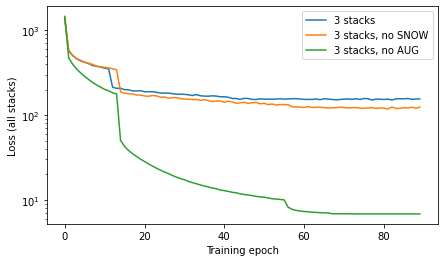

In [36]:
# plot the learninig rate
i_stack = 0
fig = plt.figure(figsize = (7,4) )

for i_stack,st in enumerate(stack_list):

    tensorboard_path = glob.glob(logdir+tag_list[i_stack]+'/*')[0]

    # read the data
    event_acc = EventAccumulator(tensorboard_path)
    event_acc.Reload()

    # Show all tags in the log file
    print(event_acc.Tags())

    trn_loss =   event_acc.Scalars('trn_loss')
    trn_frame_loss =   event_acc.Scalars('trn_frame_loss')

    val_loss =   event_acc.Scalars('val_loss')
    val_frame_loss =   event_acc.Scalars('val_frame_loss')

    lr = event_acc.Scalars('lr')
    n_stacks = event_acc.Scalars('n_stakcs')

    n_train = event_acc.Scalars('n_train')
    
    
    # convert
    trn_loss = extract_as_arrays(trn_loss)
    trn_frame_loss = extract_as_arrays(trn_frame_loss)
    n_stacks = extract_as_arrays(n_stacks)
    lr = extract_as_arrays(lr)

#     plt.plot(trn_frame_loss[1]/n_train[0][-1],trn_frame_loss[2]/st,'.',alpha = .01,c=cc[i_stack])
    if st== 0:
        plt.plot(trn_loss[1][:90],trn_loss[2][:90],c=cc[i_stack],label = "3 stacks")
    if st == 1:
        plt.plot(trn_loss[1][:90],trn_loss[2][:90],c=cc[i_stack],label = "3 stacks, no SNOW")
    if st == 2:
        plt.plot(trn_loss[1][:90],trn_loss[2][:90],c=cc[i_stack],label = "3 stacks, no AUG")

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
plt.ylabel("Loss (all stacks)")
# plt.ylabel("log(Loss) [only ]")
plt.xlabel("Training epoch")

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'AUG_loss.pdf',transparent=True,  bbox_inches='tight')

plt.show()


In [47]:
# Make a plot of the keypoints vs time 
# for i_st,st in enumerate(all_stacks):
# 
i_st = -1

cuts = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
# cuts = [.1]
n_cuts = len(cuts)
missed_stack = np.zeros((n_cuts,3,4))

for i_cutoff,p_cutoff in enumerate(cuts):


    distance_stack = []

    
    for i_st in range(3):

        # then epoch
        i_ep = -1

        # the every image 

        xy_list = keypoint_stack[i_st][i_ep][0]
        pxy_list = keypoint_stack[i_st][i_ep][1]
        kpi_list = keypoint_stack[i_st][i_ep][2]
        xy_real_list = keypoint_stack[i_st][i_ep][3]
        kpi_real_list = keypoint_stack[i_st][i_ep][4]

        distance_list = [[],[],[],[]]

        n_im = len(xy_list)

        for i_im in range(n_im):
            for i_keyp in [1,2,3]:
                kpi = kpi_list[i_im][:,0]
                xy = xy_list[i_im][kpi==i_keyp]
                pxy = pxy_list[i_im][kpi==i_keyp]
                kpi_real = kpi_real_list[i_im]
                xy_real = xy_real_list[i_im][kpi_real==i_keyp]

                xy = xy[pxy>p_cutoff,:]


                if len(xy_real) == 0:
                    # if there were no points to detect, just go on...
                    continue

                if len(xy) == 0:
                    # if there were no detections, set distance to infinity
                    d_match = np.inf*np.squeeze(np.ones_like(xy_real[:,0]))

                    if len(xy_real) == 2:
                        # catcg stupid numpy, could be more elegant
                        d_match = 800*np.array([1])
                    else:
                        d_match = 10000*np.ones_like(xy_real[:,0])

                    distance_list[i_keyp].append(d_match)

                else:        
                    # HERE there is a stupid convention conflict!
                    # the xy_real are in the the classic image space, so i,j i.e. down, right
                    # scipy is returned flipped, so j,i

                    i_net = xy[:,1]
                    j_net = xy[:,0]
                    i_real = xy_real[:,0]
                    j_real = xy_real[:,1]

                    d2 = (i_real[...,np.newaxis]-i_net[np.newaxis,...])**2 + (j_real[...,np.newaxis]-j_net[np.newaxis,...])**2
                    d = np.sqrt(d2)
                    match = np.argmin(d,1)
                    d_match =  np.min(d,1)
                    distance_list[i_keyp].append(d_match)

        distance_stack.append(distance_list)

    for i_st in range(3):
        for i_keyp in [1,2,3]:
            edges = np.arange(0,15)

            all_dist = np.concatenate(distance_stack[i_st][i_keyp])
            count,edges = np.histogram(all_dist,edges)
            count = count/len(all_dist)
            missed_stack[i_cutoff,i_st,i_keyp] = (1 - np.sum(count[:5]))*1


In [38]:
missed_stack

array([[[0.        , 0.04944444, 0.11904762, 0.15373766],
        [0.        , 0.08069004, 0.12044818, 0.29275362],
        [0.        , 0.1264624 , 0.21448864, 0.32608696]]])

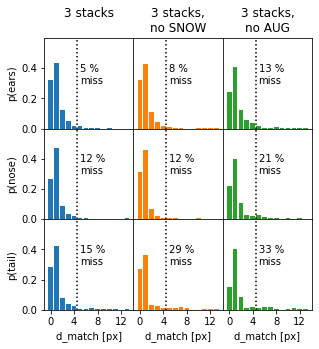

In [39]:
# Make a figure showing the performance below the cutoff 
from palettable.tableau import GreenOrange_6, Tableau_10
cc = GreenOrange_6.mpl_colors
cc = Tableau_10.mpl_colors

fig,axs = plt.subplots(3,3,figsize = (8*3/5,5) )
edges = np.arange(0,15)

for i_st in range(3):
    for i_keyp in [1,2,3]:
        ax = axs[i_keyp-1,i_st]
        
        all_dist = np.concatenate(distance_stack[i_st][i_keyp])
        count,edges = np.histogram(all_dist,edges)
        count = count/len(all_dist)
        ax.bar(edges[:-1],count,color = cc[i_st])
    
        ax.set_ylim([0,.6])
        ax.set_yticks([])
        ax.set_xticks([])

        ax.axvline(4.5,ls=':',c='k')
        missed = (1 - np.sum(count[:5]))*100
        ax.text(5,.3,'{:0.0f} %\nmiss'.format(missed))

for ax,name in zip(axs[:,0],['ears','nose','tail']):
    ax.set_yticks([0,.2,.4])
    ax.set_ylabel('p({})'.format(name) )

for ax,name in zip(axs[0,0:],['3 stacks\n', '3 stacks,\nno SNOW', '3 stacks,\nno AUG']):
    ax.set_title(name)

for ax in axs[-1,:]:
    ax.set_xticks([0,4,8,12])
    ax.set_xlabel('d_match [px]')
    
        
plt.subplots_adjust(hspace = 0,wspace=0)

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'AUG_keypoint_10.pdf',transparent=True,  bbox_inches='tight')

plt.show()


In [78]:
# Make a plot of the keypoints vs time 
# for i_st,st in enumerate(all_stacks):
# 
i_st = -1

cuts = [.1,.2,.3,.4,.5,.6,.7,.8,.9]

# cuts = [.1]

n_cuts = len(cuts)
false_stack = np.zeros((n_cuts,5,4))

for i_cutoff,p_cutoff in enumerate(cuts):


    distance_stack = []

    
    for i_st in range(3):

        # then epoch
        i_ep = -1

        # the every image 

        xy_list = keypoint_stack[i_st][i_ep][0]
        pxy_list = keypoint_stack[i_st][i_ep][1]
        kpi_list = keypoint_stack[i_st][i_ep][2]
        xy_real_list = keypoint_stack[i_st][i_ep][3]
        kpi_real_list = keypoint_stack[i_st][i_ep][4]

        distance_list = [[],[],[],[]]

        n_im = len(xy_list)

        for i_im in range(n_im):
            for i_keyp in [1,2,3]:
                kpi = kpi_list[i_im][:,0]
                xy = xy_list[i_im][kpi==i_keyp]
                pxy = pxy_list[i_im][kpi==i_keyp]
                kpi_real = kpi_real_list[i_im]
                xy_real = xy_real_list[i_im][kpi_real==i_keyp]

                xy = xy[pxy>p_cutoff,:]

                if len(xy) == 0:
                    # if there were no points to detect, just go on...
                    continue

                if len(xy_real) == 0:
                    # if there were no detections, set distance to infinity
                    d_match = np.inf*np.squeeze(np.ones_like(xy[:,0]))

                    if len(xy) == 2:
                        # catcg stupid numpy, could be more elegant
                        d_match = 800*np.array([1])
                    else:
                        d_match = 10000*np.ones_like(xy[:,0])

                    distance_list[i_keyp].append(d_match)

                else:        
                    # HERE there is a stupid convention conflict!
                    # the xy_real are in the the classic image space, so i,j i.e. down, right
                    # scipy is returned flipped, so j,i

                    i_net = xy[:,1]
                    j_net = xy[:,0]
                    i_real = xy_real[:,0]
                    j_real = xy_real[:,1]

                    d2 = (i_real[...,np.newaxis]-i_net[np.newaxis,...])**2 + (j_real[...,np.newaxis]-j_net[np.newaxis,...])**2
                    d = np.sqrt(d2)
                    match = np.argmin(d,0)
                    d_match =  np.min(d,0)
                    distance_list[i_keyp].append(d_match)

        distance_stack.append(distance_list)

    for i_st in range(3):
        for i_keyp in [1,2,3]:
            edges = np.arange(0,15)
            if len(distance_stack[i_st][i_keyp]) == 0:
                false_stack[i_cutoff,i_st,i_keyp] = 0
            else:
                all_dist = np.concatenate(distance_stack[i_st][i_keyp])
                count,edges = np.histogram(all_dist,edges)
                count = count/len(all_dist)
                false_stack[i_cutoff,i_st,i_keyp] = (1 - np.sum(count[:5]))*1 


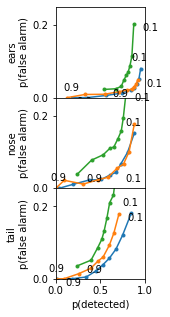

In [79]:
# PLOT THE ROI CURVE!!!
# missed_stack = 
# false_stack = 



fig,axs = plt.subplots(3,1,figsize = (8*1/5,5) )
edges = np.arange(0,15)

for i_st in range(3):
    for i_keyp in [1,2,3]:
        ax = axs[i_keyp-1]

        
        
        
        missed = missed_stack[:,i_st,i_keyp] 
        false = false_stack[:,i_st,i_keyp]
        detected = 1-missed
        

        
        if i_st == 0:
            ax.plot(detected,false,'.-',c=cc[i_st],label = '3 stack')

            for xx,yy,cut in zip(detected,false,cuts):
                if (cut == .1):
                    if (i_st == 1)*(i_keyp == 2):
                        pass
                    else:
                        ax.text(xx-.1,yy+.02,str(cut))
#                 if cut == .5:
#                     ax.text(xx-.1,yy+.02,str(cut))
                if cut == .9:
                    ax.text(xx-.1,yy+.02,str(cut))

        if i_st == 1:
            ax.plot(detected,false,'.-',c=cc[i_st],label = '3 stack, no SNOW')

            
            for xx,yy,cut in zip(detected,false,cuts):
                if (cut == .1):
                    if (i_st == 1)*(i_keyp == 2):
                        pass
                    else:
                        ax.text(xx+.1,yy-.02,str(cut))
#                 if cut == .5:
#                     ax.text(xx-.1,yy-.02,str(cut))
                if cut == .9:
                    ax.text(xx+.1,yy-.02,str(cut))

        if i_st == 2:
            ax.plot(detected,false,'.-',c=cc[i_st],label = '3 stack, no AUG')

            
            for xx,yy,cut in zip(detected,false,cuts):
                if (cut == .1):
                    if (i_st == 1)*(i_keyp == 2):
                        pass
                    else:
                        ax.text(xx+.1,yy-.02,str(cut))
#                 if cut == .5:
#                     ax.text(xx-.1,yy-.02,str(cut))
                if cut == .9:
                    ax.text(xx+.1,yy-.02,str(cut))        
        
        ax.set_xlim([0,1])
        ax.set_ylim([0,.25])
        ax.set_xticks([])
        ax.set_yticks([])            
        

                    
plt.subplots_adjust(hspace = 0,wspace=0)
        
for ax,name in zip(axs[:],['ears','nose','tail']):
    ax.set_yticks([0,.2])
    ax.set_ylabel('{}\np(false alarm)'.format(name) )

# for ax,name in zip(axs,all_stacks):
#     ax.set_title("{} stacks".format(name))


for ax in [axs[-1]]:
    ax.set_xticks([0,.5,1])
    ax.set_xlabel('p(detected)')
    
fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'AUG_ROCish.pdf',transparent=True,  bbox_inches='tight')

plt.show()


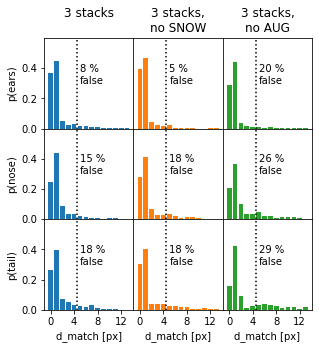

In [76]:
# Make a figure showing the performance below the cutoff 
from palettable.tableau import GreenOrange_6, Tableau_10
cc = GreenOrange_6.mpl_colors
cc = Tableau_10.mpl_colors

fig,axs = plt.subplots(3,3,figsize = (8*3/5,5) )
edges = np.arange(0,15)

for i_st in range(3):
    for i_keyp in [1,2,3]:
        ax = axs[i_keyp-1,i_st]
        
        all_dist = np.concatenate(distance_stack[i_st][i_keyp])
        count,edges = np.histogram(all_dist,edges)
        count = count/len(all_dist)
        ax.bar(edges[:-1],count,color = cc[i_st])
    
        ax.set_ylim([0,.6])
        ax.set_yticks([])
        ax.set_xticks([])

        ax.axvline(4.5,ls=':',c='k')
        missed = (1 - np.sum(count[:5]))*100
        ax.text(5,.3,'{:0.0f} %\nfalse'.format(missed))

for ax,name in zip(axs[:,0],['ears','nose','tail']):
    ax.set_yticks([0,.2,.4])
    ax.set_ylabel('p({})'.format(name) )

for ax,name in zip(axs[0,0:],['3 stacks\n', '3 stacks,\nno SNOW', '3 stacks,\nno AUG']):
    ax.set_title(name)
    
for ax in axs[-1,:]:
    ax.set_xticks([0,4,8,12])
    ax.set_xlabel('d_match [px]')
    
        
plt.subplots_adjust(hspace = 0,wspace=0)

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'AUG_keypoint_net_as_reference_10.pdf',transparent=True,  bbox_inches='tight')

plt.show()


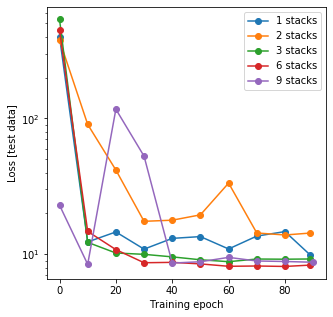

In [173]:
from palettable.tableau import GreenOrange_6, Tableau_10
cc = GreenOrange_6.mpl_colors
cc = Tableau_10.mpl_colors

plt.figure(figsize = (5,5) )
for i_st,st in enumerate(all_stacks):
    
    test_epochs = np.hstack((np.arange(0,90,10),89))
    if st == 9:
#         test_epochs = np.hstack((np.arange(0,120,10),119))
        test_epochs[-1] += 1
    
#     plt.plot(test_epochs,np.log(ep_stack[i]),'o-',label = "{} stacks".format(st) )
    
    sigma = 2
#     for i_ep,ep in enumerate(test_epochs):
#         dat = frame_stack[i_st][i_ep]
#         plt.plot(ep * np.ones_like(dat) + sigma*np.random.normal(size = len(dat),loc = 0), dat,'.' , alpha = 0.41 ,c=cc[i_st] )
    
    
    median_loss = [np.median(fr) for fr in frame_stack[i_st] ]
    mean_loss = [np.mean(fr) for fr in frame_stack[i_st] ]

#     plt.plot(test_epochs,median_loss,'o-',label = "{} stacks".format(st) ,c=cc[i_st])
    
    plt.plot(test_epochs,mean_loss,'o-',label = "{} stacks".format(st) ,c=cc[i_st])

    
ax = plt.gca()    
ax.set_yscale('log')
    
plt.legend()
plt.ylabel("Loss [test data]")
# plt.ylabel("log(Loss) [only ]")
plt.xlabel("Training epoch")

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'stacks_test.pdf',transparent=True,  bbox_inches='tight')

plt.show()

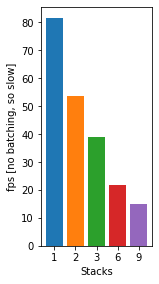

In [35]:
plt.figure(figsize = (2,4.4) )

inf_speed = [81.5,53.5,39.1,21.9,14.9]
plt.bar([1,2,3,4,5],inf_speed,color = cc)

ax = plt.gca()
ax.set_xticks([1,2,3,4,5])
ax.set_xticklabels([1,2,3,6,9])
plt.xlabel('Stacks')
plt.ylabel('fps [no batching, so slow]')

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'stacks_speed.pdf',transparent=True,  bbox_inches='tight')
plt.show()


In [30]:
# also plot the learning rate and the training loss as a func of iterations and time 

logdir = '/home/chrelli/git/3ddd_mouse_tracker/analysis/runs/'

stack_list = [1,2,3,6,9]
tag_list = ['Oct26_12-29-07_CE-01','Oct27_09-07-18_CE-01','Oct26_20-51-12_CE-01','Oct26_16-56-27_CE-01','Oct26_23-26-01_CE-01']

# from here https://gist.github.com/tomrunia/1e1d383fb21841e8f144

# from tensorflow.python.summary.event_accumulator import EventAccumulator
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib as mpl
import matplotlib.pyplot as plt

# Loading too much data is slow...
tf_size_guidance = {
        'compressedHistograms': 10,
        'images': 0,
        'scalars': 100,
        'histograms': 1
    }


def extract_as_arrays(lr):
    # unpacks from the tensorboard logs
    lr_v = np.array([x[2] for x in lr])
    # the steps
    lr_s = np.array([x[1] for x in lr])
    # get the time and zero to first time
    lr_t = np.array([x[0] for x in lr])
    lr_t -= lr_t[0]
    
    return [lr_t,lr_s,lr_v]



{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


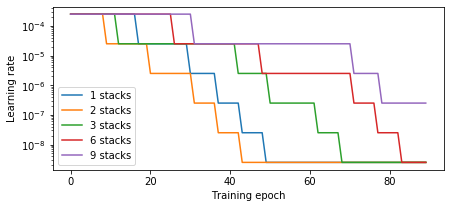

In [34]:
# plot the learninig rate
i_stack = 0
fig = plt.figure(figsize = (7,3) )

for i_stack,st in enumerate(stack_list):

    tensorboard_path = glob.glob(logdir+tag_list[i_stack]+'/*')[0]

    # read the data
    event_acc = EventAccumulator(tensorboard_path)
    event_acc.Reload()

    # Show all tags in the log file
    print(event_acc.Tags())

    trn_loss =   event_acc.Scalars('trn_loss')
    trn_frame_loss =   event_acc.Scalars('trn_frame_loss')

    val_loss =   event_acc.Scalars('val_loss')
    val_frame_loss =   event_acc.Scalars('val_frame_loss')

    lr = event_acc.Scalars('lr')
    n_stacks = event_acc.Scalars('n_stakcs')

    # convert
    trn_loss = extract_as_arrays(trn_loss)
    trn_frame_loss = extract_as_arrays(trn_frame_loss)
    n_stacks = extract_as_arrays(n_stacks)
    lr = extract_as_arrays(lr)

    plt.plot(lr[1][:90],lr[2][:90],c=cc[i_stack],label = "{} stacks".format(st))

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
plt.ylabel("Learning rate")
# plt.ylabel("log(Loss) [only ]")
plt.xlabel("Training epoch")

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'stacks_lr.pdf',transparent=True,  bbox_inches='tight')

plt.show()


{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


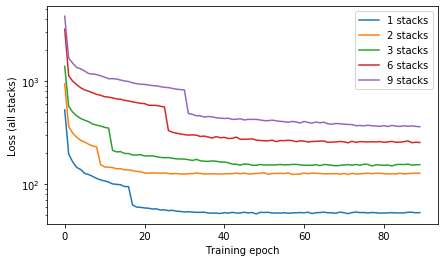

In [32]:
# plot the learninig rate
i_stack = 0
fig = plt.figure(figsize = (7,4) )

for i_stack,st in enumerate(stack_list):

    tensorboard_path = glob.glob(logdir+tag_list[i_stack]+'/*')[0]

    # read the data
    event_acc = EventAccumulator(tensorboard_path)
    event_acc.Reload()

    # Show all tags in the log file
    print(event_acc.Tags())

    trn_loss =   event_acc.Scalars('trn_loss')
    trn_frame_loss =   event_acc.Scalars('trn_frame_loss')

    val_loss =   event_acc.Scalars('val_loss')
    val_frame_loss =   event_acc.Scalars('val_frame_loss')

    lr = event_acc.Scalars('lr')
    n_stacks = event_acc.Scalars('n_stakcs')

    n_train = event_acc.Scalars('n_train')
    
    
    # convert
    trn_loss = extract_as_arrays(trn_loss)
    trn_frame_loss = extract_as_arrays(trn_frame_loss)
    n_stacks = extract_as_arrays(n_stacks)
    lr = extract_as_arrays(lr)

#     plt.plot(trn_frame_loss[1]/n_train[0][-1],trn_frame_loss[2]/st,'.',alpha = .01,c=cc[i_stack])
    
    plt.plot(trn_loss[1][:90],trn_loss[2][:90],c=cc[i_stack],label = "{} stacks".format(st))

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
plt.ylabel("Loss (all stacks)")
# plt.ylabel("log(Loss) [only ]")
plt.xlabel("Training epoch")

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'stacks_loss.pdf',transparent=True,  bbox_inches='tight')

plt.show()


{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}
{'images': [], 'audio': [], 'histograms': [], 'scalars': ['trn_loss', 'val_loss', 'trn_frame_loss', 'val_frame_loss', 'lr', 'n_train', 'n_val', 'n_stakcs'], 'distributions': [], 'tensors': [], 'graph': False, 'meta_graph': False, 'run_metadata': []}


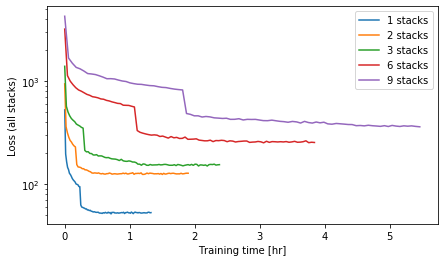

In [33]:
# plot the learninig rate
i_stack = 0
fig = plt.figure(figsize = (7,4) )

for i_stack,st in enumerate(stack_list):

    tensorboard_path = glob.glob(logdir+tag_list[i_stack]+'/*')[0]

    # read the data
    event_acc = EventAccumulator(tensorboard_path)
    event_acc.Reload()

    # Show all tags in the log file
    print(event_acc.Tags())

    trn_loss =   event_acc.Scalars('trn_loss')
    trn_frame_loss =   event_acc.Scalars('trn_frame_loss')

    val_loss =   event_acc.Scalars('val_loss')
    val_frame_loss =   event_acc.Scalars('val_frame_loss')

    lr = event_acc.Scalars('lr')
    n_stacks = event_acc.Scalars('n_stakcs')

    n_train = event_acc.Scalars('n_train')
    
    
    # convert
    trn_loss = extract_as_arrays(trn_loss)
    trn_frame_loss = extract_as_arrays(trn_frame_loss)
    n_stacks = extract_as_arrays(n_stacks)
    lr = extract_as_arrays(lr)
    
    

#     plt.plot(trn_frame_loss[1]/n_train[0][-1],trn_frame_loss[2]/st,'.',alpha = .01,c=cc[i_stack])
    
    plt.plot(trn_loss[0][:90]/(60*60),trn_loss[2][:90],c=cc[i_stack],label = "{} stacks".format(st))

ax = plt.gca()
ax.set_yscale('log')
plt.legend()
plt.ylabel("Loss (all stacks)")
# plt.ylabel("log(Loss) [only ]")
plt.xlabel("Training time [hr]")

fig_folder = '/home/chrelli/git/3ddd_mouse_tracker/analysis/revision_figures/profile_network/'
plt.savefig(fig_folder + 'stacks_loss_time.pdf',transparent=True,  bbox_inches='tight')

plt.show()
